# Support Vector Clustering (SVC)

### Uma simples base de dados brinquedo será utilizada para ilustrar a utilização do Support Vector Clustering para solução de um problema de clustering. A base de dados a ser analisada consiste na make_moons dataset gerada por meio da biblioteca [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

### Bibliotecas a serem utilizadas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
from tqdm import tqdm
import sklearn.datasets
import time
plt.style.use('seaborn-whitegrid')

### Algoritmo Support Vector Clustering (SVC)

In [2]:
class SupportVectorClustering():

    def __init__(self):
        pass

    def dataset(self, xs):
        self.xs = xs # dataset
        self.N = len(xs) # número de instâncias

    def parameters(self, p=0.1, q=1):
        self.q = q # parâmetro kernel width 
        self.p = p # fração de bounded support vectors (BSVs) 
        self.C = 1/(self.N*p) # constante de penalização (1/C >= 1)
    
    def kernel(self, x1, x2):
        return np.exp(-self.q*np.sum((x1-x2)**2, axis=-1)) # gaussian kernel 

    def kernel_matrix(self):
        self.km = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(self.N):
                self.km[i,j] = self.kernel(self.xs[i], self.xs[j])

    # método de otimização
    def find_beta(self): 
        beta = cvx.Variable(self.N) # vetor de N dimensões
        objective = cvx.Maximize(cvx.sum(beta) - cvx.quad_form(beta, self.km))  # função objetivo 
        constraints = [0 <= beta, beta <= self.C, cvx.sum(beta) == 1] # restrições 
        prob = cvx.Problem(objective, constraints) # definição do problema de otimização
        prob.solve() # solução do problema de otimização
        self.beta = beta.value # valores ótimos das variáveis beta 

    # cálculo do raio da hiperesfera
    def r_func(self, x):
        return self.kernel(x, x) - 2*np.sum([self.beta[i]*self.kernel(self.xs[i],x) for i in range(self.N)]) + self.beta.T@self.km@self.beta
        # python > 3.5 @ matrix multiplication

    # amostragem de segmentos entre dois pontos
    def sample_segment(self,x1,x2,r,n=10):
        adj = True
        for i in range(n):
            x = x1 + (x2-x1)*i/(n+1) 
            if self.r_func(x) > r:
                adj = False
                return adj
        return adj
    
    # definição da matriz de adjacência
    def cluster(self):
        print('Calculating adjacency matrix... \n')
        svs_tmp = np.array(self.beta < self.C)*np.array(self.beta > 10**-8) # svs: 0 < beta < C
        self.svs = np.where(svs_tmp == True)[0] # índice support vectors 
        bsvs_tmp = np.array(self.beta >= self.C) # bsvs: beta == C ??
        self.bsvs = np.where(bsvs_tmp == True)[0] # índice bounded support vectors
        self.r = np.mean([self.r_func(self.xs[i]) for i in self.svs[:5]]) # why 5??
        self.adj = np.zeros((self.N, self.N)) # matriz adjacência
        # checar adjacência entre pontos 
        for i in tqdm(range(self.N)):
            if i not in self.bsvs:
                for j in range(i, self.N):
                    if j not in self.bsvs:
                        self.adj[i,j] = self.adj[j,i] = self.sample_segment(self.xs[i],self.xs[j],self.r)
    
    # definição dos clusters
    def return_clusters(self):
        ids = list(range(self.N))
        self.clusters = {}
        num_clusters = 0
        while ids:
            num_clusters += 1
            self.clusters[num_clusters] = []
            curr_id = ids.pop(0)
            queue = [curr_id]
            while queue:
                cid = queue.pop(0)
                for i in ids:
                    if self.adj[i,cid]:
                        queue.append(i)
                        ids.remove(i)
                self.clusters[num_clusters].append(cid)
        print('\n')
        print(f'The number of clusters is {num_clusters}')

    def plot_clusters(self):
        colors = {1:'r',2:'b',3:'g',4:'c',5:'m',6:'y',7:'k',8:'b',9:'c'}
        for num_cluster, samples in self.clusters.items():
            cluster = np.empty((len(samples), 2))
            for idx, sample in enumerate(samples):
                cluster[idx] = self.xs[sample]
            plt.scatter(cluster[:,0], cluster[:,1], c = colors[num_cluster], label = num_cluster)
        plt.legend()
        plt.show()

### Main()

Importação dos dados

In [3]:
def define_data(REBUILD_DATA = False, N_SAMPLES = 50):
    if REBUILD_DATA == True:
        ms = sklearn.datasets.make_moons(n_samples=N_SAMPLES,noise=0.1)[0]
        np.save('simple_data.npy', ms)
    X = np.load('simple_data.npy')
    return X

  0%|                                                  | 0/100 [00:00<?, ?it/s]

Calculating adjacency matrix... 



100%|████████████████████████████████████████| 100/100 [01:01<00:00,  1.61it/s]




The number of clusters is 2


Processing Time: 63.47559475898743 seconds


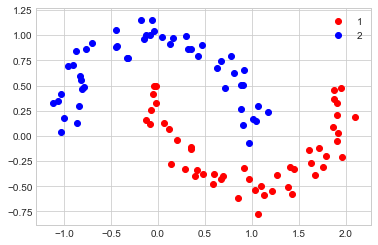

In [4]:
# Database
X = define_data(REBUILD_DATA = False, N_SAMPLES=50)
# Iniciar algoritmo
start_time = time.time()
svc = SupportVectorClustering()
svc.dataset(X) # inserção da database
svc.parameters(p=0.002, q=6.5) # definição dos parâmetros
svc.kernel_matrix() # cálculo da matriz kernel
svc.find_beta() # solução do problema de otimização
svc.cluster() # cálculo da matriz de adjacência
svc.return_clusters() # define clusters
print('\n')
print(f'Processing Time: {time.time() - start_time} seconds')
svc.plot_clusters() # plot